# Prestressed Sections

This example demonstrates how to carry out an analysis of a prestressed concrete section using *concreteproperties*. We start by importing the necessary modules.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sectionproperties.pre.library.primitive_sections import rectangular_section

import concreteproperties.stress_strain_profile as ssp
from concreteproperties.material import Concrete, SteelStrand
from concreteproperties.pre import add_bar_rectangular_array
from concreteproperties.prestressed_section import PrestressedSection
from concreteproperties.results import MomentCurvatureResults

## Assign Materials
In this example we will be creating material properties for both a service and ultimate analysis. 

**Concrete:** C50/60 concrete will be used (Eurocode). The service analysis will use a non-linear stress-strain profile, while the ultimate analysis will use a bilinear stress-strain profile with relevant material factors applied ($\gamma_c = 1.5$).

**Strand:** Y1860S7 strand will be used. The ultimate profile has the relevant material factors applied ($\gamma_s = 1.1$). The service profile will also be used for short-term analysis where the prestressing stress after short-term losses is $\sigma_{p,0} = 1274.4$ MPa. The ultimate profile will also be used for long-term analysis where the prestressing stress after long-term losses is $\sigma_{p,\infty} = 1148.6$ MPa.

In [2]:
concrete_service = Concrete(
    name="C50/60 Concrete (Service)",
    density=2.4e-6,
    stress_strain_profile=ssp.EurocodeNonLinear(
        elastic_modulus=37.0e3,
        ultimate_strain=0.0035,
        compressive_strength=58,
        compressive_strain=0.00245,
        tensile_strength=4.1,
        tension_softening_stiffness=10e3,
    ),
    ultimate_stress_strain_profile=ssp.BilinearStressStrain(
        compressive_strength=50 / 1.5,
        compressive_strain=0.00175,
        ultimate_strain=0.0035,
    ),
    flexural_tensile_strength=4.1,
    colour="lightgrey",
)

concrete_ultimate = Concrete(
    name="C50/60 Concrete (Ultimate)",
    density=2.4e-6,
    stress_strain_profile=ssp.ConcreteLinearNoTension(
        elastic_modulus=37.0e3,
        ultimate_strain=0.0035,
        compressive_strength=50 / 1.5,
    ),
    ultimate_stress_strain_profile=ssp.BilinearStressStrain(
        compressive_strength=50 / 1.5,
        compressive_strain=0.00175,
        ultimate_strain=0.0035,
    ),
    flexural_tensile_strength=4.1,
    colour="lightgrey",
)

strand_service = SteelStrand(
    name="Y1860S7 Strand (Service)",
    density=7.85e-6,
    stress_strain_profile=ssp.StrandHardening(
        yield_strength=1674,
        elastic_modulus=195e3,
        fracture_strain=0.035,
        breaking_strength=1860,
    ),
    colour="grey",
    prestress_stress=1274.4,
)

strand_ultimate = SteelStrand(
    name="Y1860S7 Strand (Ultimate)",
    density=7.85e-6,
    stress_strain_profile=ssp.StrandHardening(
        yield_strength=1522,
        elastic_modulus=195e3,
        fracture_strain=0.035,
        breaking_strength=1691,
    ),
    colour="grey",
    prestress_stress=1148.6,
)

We can compare the service and ultimate stress-strain profiles for the concrete and the strand.

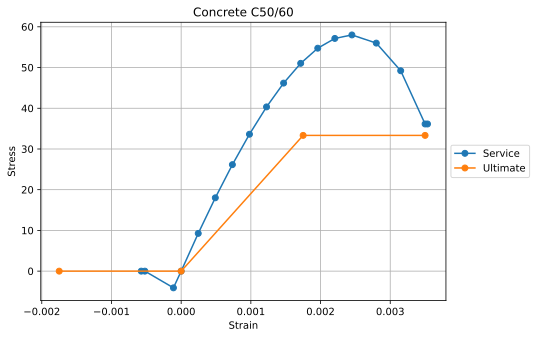

In [3]:
# combine both stress-strain profiles on the same plot
ax = concrete_service.stress_strain_profile.plot_stress_strain(render=False)
concrete_service.ultimate_stress_strain_profile.plot_stress_strain(ax=ax)
ax.lines[0].set_label("Service")
ax.lines[1].set_label("Ultimate")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.title("Concrete C50/60")
plt.show()

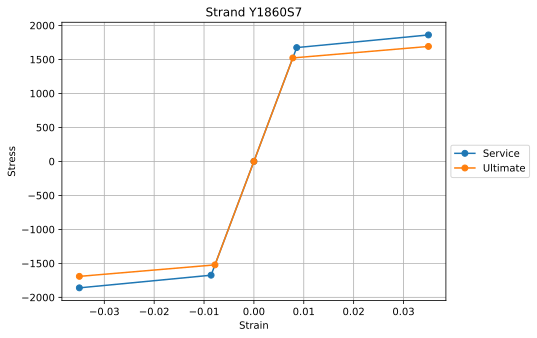

In [4]:
# combine both stress-strain profiles on the same plot
ax = strand_service.stress_strain_profile.plot_stress_strain(render=False)
strand_ultimate.stress_strain_profile.plot_stress_strain(ax=ax)
ax.lines[0].set_label("Service")
ax.lines[1].set_label("Ultimate")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.title("Strand Y1860S7")
plt.show()

## Create Prestressed Geometry
The section being analysed is a 1100D x 1500W hollow box with a 250THK web and flange. 15.2 mm strands with a cross-sectional area of 140 mm$^2$ are used. Each web has 3 vertically spaced tendons containing 8 strands, while the bottom flange has two horizontally spaced tendons containing 9 strands. Two ``PrestressedConcrete`` objects are created, one for service analysis (short-term) and one for ultimate (long-term) analysis. 

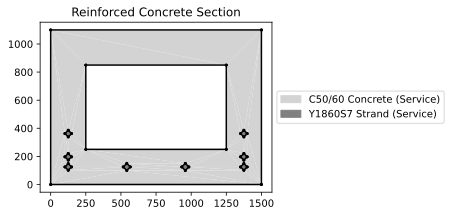

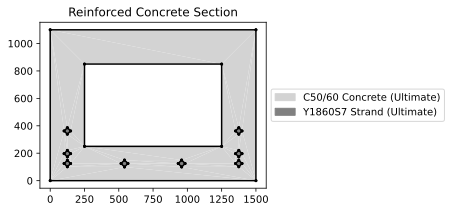

<Axes: title={'center': 'Reinforced Concrete Section'}>

In [5]:
# box properties
d_box = 1100  # box depth
b_box = 1500  # box width
t_box = 250  # box thickness

# strand properties
strand_area = 140  # area of each strand
duct_diameter = 72  # diameter of the tendon ducts
strand_d1 = 125  # distance from bottom to layer 1
strand_d2 = strand_d1 + 72  # distance from bottom to layer 2
strand_d3 = strand_d2 + 165.4  # distance from bottom to layer 3

# generate a service and ultimate PrestressedConcrete object
conc_secs = []
concrete_props = [concrete_service, concrete_ultimate]
strand_props = [strand_service, strand_ultimate]

for idx, concrete_prop in enumerate(concrete_props):
    # construct concrete hollow box
    box_outer = rectangular_section(d=d_box, b=b_box, material=concrete_prop)
    box_inner = rectangular_section(
        d=d_box - 2 * t_box, b=b_box - 2 * t_box
    ).align_center(align_to=box_outer)
    box = box_outer - box_inner

    # add web strands (6 x 8 strand tendons)
    # lower two sets
    geom = add_bar_rectangular_array(
        geometry=box,
        area=8 * strand_area,
        material=strand_props[idx],
        n_x=2,
        x_s=b_box - t_box,
        n_y=2,
        y_s=strand_d2 - strand_d1,
        anchor=(t_box / 2, strand_d1),
    )

    # top set
    geom = add_bar_rectangular_array(
        geometry=geom,
        area=8 * strand_area,
        material=strand_props[idx],
        n_x=2,
        x_s=b_box - t_box,
        anchor=(t_box / 2, strand_d3),
    )

    # add flange strands (2 x 9 strand tendons)
    geom = add_bar_rectangular_array(
        geometry=geom,
        area=9 * strand_area,
        material=strand_props[idx],
        n_x=2,
        x_s=(b_box - t_box) / 3,
        anchor=(t_box / 2 + (b_box - t_box) / 3, strand_d1),
    )

    # create prestressed section objects
    conc_secs.append(PrestressedSection(geom))

# extract prestressed section objects
conc_sec_serv = conc_secs[0]
conc_sec_ult = conc_secs[1]

# plot each object
conc_sec_serv.plot_section()
conc_sec_ult.plot_section()

## Calculate Area Properties
The area properties of the prestressed section are automatically calculated and can be printed as follows.

In [6]:
gross_props_serv = conc_sec_serv.get_gross_properties()
gross_props_ult = conc_sec_ult.get_gross_properties()
gross_props_serv.print_results(fmt=".3e")

    Gross Concrete Section Properties     
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Property                  ┃      Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ Total Area                │  1.050e+06 │
│ Concrete Area             │  1.041e+06 │
│ Lumped Reinforcement Area │  0.000e+00 │
│ Strand Area               │  9.240e+03 │
│ Axial Rigidity (EA)       │  4.031e+10 │
│ Mass (per unit length)    │  2.570e+00 │
│ Perimeter                 │  5.200e+03 │
│ E.Qx                      │  2.166e+13 │
│ E.Qy                      │  3.023e+13 │
│ x-Centroid                │  7.500e+02 │
│ y-Centroid                │  5.373e+02 │
│ x-Centroid (Gross)        │  7.500e+02 │
│ y-Centroid (Gross)        │  5.500e+02 │
│ E.Ixx_g                   │  1.731e+16 │
│ E.Iyy_g                   │  3.270e+16 │
│ E.Ixy_g                   │  1.624e+16 │
│ E.Ixx_c                   │  5.676e+15 │
│ E.Iyy_c                   │  1.003e+16 │
│ E.Ixy_c                   │ -1.600e+01 │
│ E.I11                     │  1.003e+16 │
│ E.I22                     │  5.676e+15 │
│ Principal Axis Angle      │ -1.571e+00 │
│ E.Zxx+                    │  1.009e+13 │
│ E.Zxx-                    │  1.056e+13 │
│ E.Zyy+                    │  1.337e+13 │
│ E.Zyy-                    │  1.337e+13 │
│ E.Z11+                    │  1.337e+13 │
│ E.Z11-                    │  1.337e+13 │
│ E.Z22+                    │  1.056e+13 │
│ E.Z22-                    │  1.009e+13 │
│ Ultimate Concrete Strain  │  3.500e-03 │
│ n_prestress               │  1.178e+07 │
│ m_prestress               │ -3.972e+09 │
└───────────────────────────┴────────────┘

The gross properties for ``PrestressedConcrete`` objects also report the total axial prestressing force and the induced bending moment.

In [7]:
print(f"P_0 = {gross_props_serv.n_prestress / 1e3:.0f} kN")
print(f"M_0 = {gross_props_serv.m_prestress / 1e6:.0f} kN.m")
print(f"P_inf = {gross_props_ult.n_prestress / 1e3:.0f} kN")
print(f"M_inf = {gross_props_ult.m_prestress / 1e6:.0f} kN.m")

P_0 = 11775 kN
M_0 = -3972 kN.m
P_inf = 10613 kN
M_inf = -3580 kN.m


## Design Actions
In this example, the prestressed girder is 35.5 m long. It has a superimposed dead load of 3 kN/m and a live load of 10 kN/m. The ultimate load factors are $\gamma_g = 1.2$, $\gamma_q = 1.5$ and $\gamma_p = 1.0$ (note that unfactored prestressing actions are automatically included in the analysis).

The resulting design moments can be calculated, with the self-weight determined from the computed gross properties. Note that the initial prestressing force was selected to balance the moment due to self-weight.

In [8]:
# design actions
L = 35500  # length of girder in [mm]
g_sw = gross_props_serv.mass * 9.81  # self weight in [N/mm]
g_si = 3  # superimposed dead load in [N/mm]
q = 10  # live load in [N/mm]

# calculate moments
m_g_sw = g_sw * L * L / 8  # moment due to self weight
m_g_si = g_si * L * L / 8  # moment due to superimposed dead load
m_q = q * L * L / 8  # moment due to live load
m_ed = 1.2 * (m_g_sw + m_g_si) + 1.5 * m_q

print(f"M_g_sw = {m_g_sw / 1e6:.0f} kN.m")
print(f"M_g_si = {m_g_si / 1e6:.0f} kN.m")
print(f"M_q = {m_q / 1e6:.0f} kN.m")
print(f"M_Ed = {m_ed / 1e6:.0f} kN.m")

M_g_sw = 3972 kN.m
M_g_si = 473 kN.m
M_q = 1575 kN.m
M_Ed = 7697 kN.m


## Stress Analysis

### Prestressing Actions Only
For academic purposes, the stresses resulting from prestressing only (no self-weight) can be visualised by not supplying any bending moment to ``PrestressedSection.calculate_uncracked_stress()`` (default is ``m=0``).

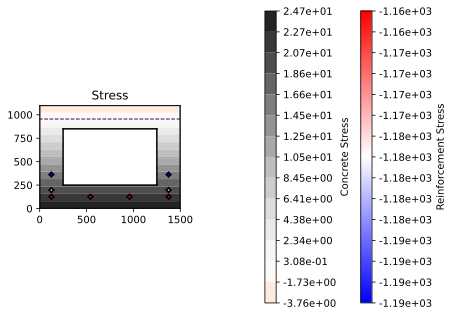

<Axes: title={'center': 'Stress'}>

In [9]:
# stress due to prestressing only
uncr_stress_p = conc_sec_serv.calculate_uncracked_stress()
uncr_stress_p.plot_stress()

Without any self-weight, there is a small region of tension at the top of the girder. We can carry-out a cracked analysis for this loading condition to determine the cracked area properties, the cracking moments and concrete and strand stresses assuming a cracked section (linear concrete with no tensile capacity).

 Cracked Concrete Section  
        Properties         
┏━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Property   ┃      Value ┃
┡━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ theta      │  0.000e+00 │
│ n          │  1.178e+07 │
│ m          │  0.000e+00 │
│ m_cr_pos   │  8.228e+09 │
│ m_cr_neg   │ -9.248e+07 │
│ d_nc       │  8.528e+02 │
│ E.A_cr     │  2.659e+10 │
│ E.Qx_cr    │  8.262e+12 │
│ E.Qy_cr    │  1.994e+13 │
│ x-Centroid │  7.500e+02 │
│ y-Centroid │  3.107e+02 │
│ E.Ixx_g_cr │  4.163e+15 │
│ E.Iyy_g_cr │  2.241e+16 │
│ E.Ixy_g_cr │  6.196e+15 │
│ E.Ixx_c_cr │  1.596e+15 │
│ E.Iyy_c_cr │  7.456e+15 │
│ E.Ixy_c_cr │  1.100e+01 │
│ E.Iuu_cr   │  1.596e+15 │
│ E.I11_cr   │  7.456e+15 │
│ E.I22_cr   │  1.596e+15 │
│ phi_cr     │ -1.571e+00 │
└────────────┴────────────┘

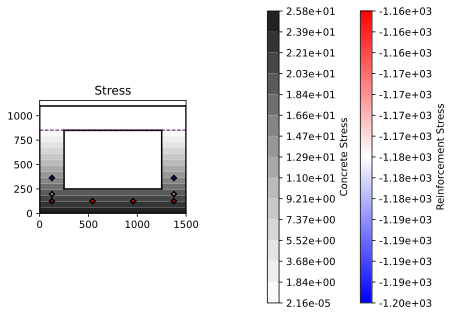

<Axes: title={'center': 'Stress'}>

In [10]:
cr_p_serv = conc_sec_serv.calculate_cracked_properties(m_ext=0)
cr_p_ult = conc_sec_ult.calculate_cracked_properties(m_ext=0)
cr_p_serv.print_results(fmt=".3e")
cr_stress_p_serv = conc_sec_serv.calculate_cracked_stress(cracked_results=cr_p_serv)
cr_stress_p_serv.plot_stress()

Note that the concrete and strand stresses have slightly increased now that the concrete cannot resist any tensile stresses.

Also of interest are the cracking moments. ``m_cr_pos`` reports the sagging bending moment required for the stress to exceed the flexural tensile strength of the concrete at the base of the section when combined with the prestressing actions. ``m_cr_neg`` reports the hogging bending moment required for the stress to exceed the flexural tensile strength of the concrete at the top of the section when combined with the prestressing actions. Note if the flexural tensile strength of the concrete is set to zero, these values show the moments at which the concrete begins to experience tensile stresses. 

In [11]:
print(f"M_cr_pos_s = {cr_p_serv.m_cr[0] / 1e6:.0f} kN.m")
print(f"M_cr_pos_u = {cr_p_ult.m_cr[0] / 1e6:.0f} kN.m")
print(f"M_cr_neg_s = {cr_p_serv.m_cr[1] / 1e6:.0f} kN.m")
print(f"M_cr_neg_u = {cr_p_ult.m_cr[1] / 1e6:.0f} kN.m")

M_cr_pos_s = 8228 kN.m
M_cr_pos_u = 7532 kN.m
M_cr_neg_s = -92 kN.m
M_cr_neg_u = -194 kN.m


### Transfer
The stresses at transfer ($G_{sw} + P$) can be determined by setting ``m=m_g_sw`` in the ``calculate_uncracked_stress()`` method. It was previously found that the moment due to self-weight was equal to the prestressing moment. As a result, the prestressed section is under pure compression. 

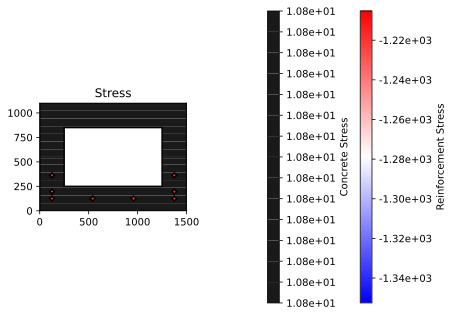

<Axes: title={'center': 'Stress'}>

In [12]:
# stress due to G_sw + P at t = 0
uncr_stress_t0 = conc_sec_serv.calculate_uncracked_stress(m=m_g_sw)
uncr_stress_t0.plot_stress()

### Service Load
The stresses under long-term service loads can be found by using the ``PrestressedConcrete`` object created for ultimate analysis (with long-term losses incorporated into the prestressing stress). 

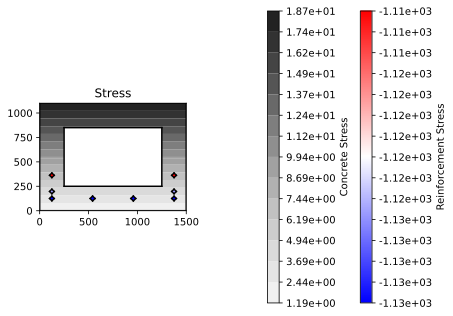

<Axes: title={'center': 'Stress'}>

In [13]:
# stress due to G + Q + P at t = inf
uncr_stress_tinf = conc_sec_ult.calculate_uncracked_stress(m=m_g_sw + m_g_si + m_q)
uncr_stress_tinf.plot_stress()

The entire concrete section is still under compression and within limits, thus the level of prestressing stress is acceptable.

## Ultimate Analysis
The ultimate bending capacity of the prestressed concrete section be found by calling the ``ultimate_bending_capacity()`` method.

In [14]:
ult_res = conc_sec_ult.ultimate_bending_capacity()
ult_res.print_results()

            Ultimate Bending Results            
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Property                     ┃         Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Bending Angle - theta        │  0.000000e+00 │
│ Neutral Axis Depth - d_n     │  4.661936e+02 │
│ Neutral Axis Parameter - k_u │  4.781473e-01 │
│ Axial Force                  │ -1.059989e+01 │
│ Bending Capacity - m_x       │  1.063704e+10 │
│ Bending Capacity - m_y       │  5.245209e-06 │
│ Bending Capacity - m_xy      │  1.063704e+10 │
└──────────────────────────────┴───────────────┘

In [15]:
print(f"d_n = {ult_res.d_n:.1f} mm")
print(f"M_Rd = {ult_res.m_x / 1e6:.0f} kN.m")
print(f"M_Ed = {m_ed / 1e6:.0f} kN.m")
print("M_Rd >= M_Ed, therefore OK!")

d_n = 466.2 mm
M_Rd = 10637 kN.m
M_Ed = 7697 kN.m
M_Rd >= M_Ed, therefore OK!


The ultimate bending stresses can be visualised by calling the ``calculate_ultimate_stress()`` method. The bilinear concrete profile is depicted well in the below plot.

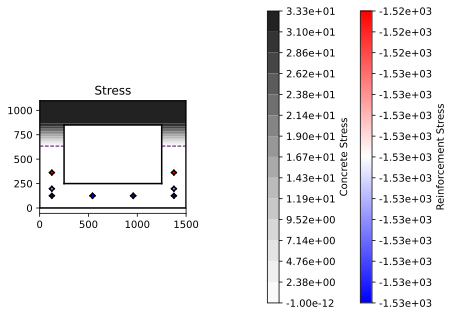

<Axes: title={'center': 'Stress'}>

In [16]:
ult_stress = conc_sec_ult.calculate_ultimate_stress(ultimate_results=ult_res)
ult_stress.plot_stress()

## Moment Curvature Analysis
We will now compute the moment curvature response of the prestressed concrete section. It should be noted that the service analysis is unfactored, while the ultimate analysis contains the material reduction factors.

In [17]:
mk_serv = conc_sec_serv.moment_curvature_analysis(kappa_mult=1.1, progress_bar=False)

In [18]:
mk_ult = conc_sec_ult.moment_curvature_analysis(kappa_mult=1.1, progress_bar=False)

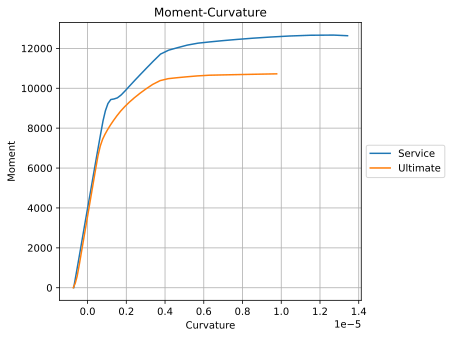

<Axes: title={'center': 'Moment-Curvature'}, xlabel='Curvature', ylabel='Moment'>

In [19]:
MomentCurvatureResults.plot_multiple_results(
    moment_curvature_results=[mk_serv, mk_ult],
    labels=["Service", "Ultimate"],
    fmt="-",
)

### Service Stresses
The stresses at any point on the moment curvature diagram can be visualised by calling the ``calculate_service_stress()`` method. Here we examine the stresses of both analyses under zero external moment.

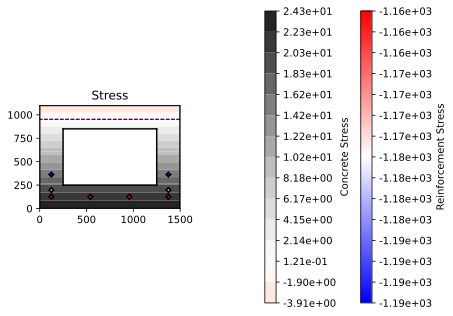

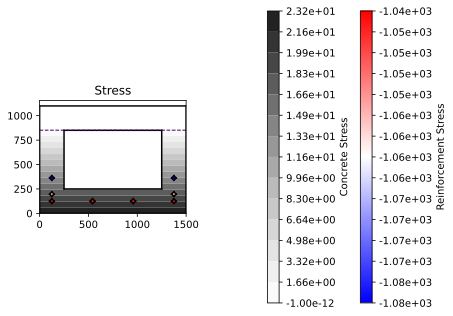

<Axes: title={'center': 'Stress'}>

In [20]:
serv_stress_s_1 = conc_sec_serv.calculate_service_stress(
    moment_curvature_results=mk_serv, m=None, kappa=mk_serv.kappa[0]
)
serv_stress_u_1 = conc_sec_ult.calculate_service_stress(
    moment_curvature_results=mk_ult, m=None, kappa=mk_ult.kappa[0]
)
serv_stress_s_1.plot_stress()
serv_stress_u_1.plot_stress()

The service analysis has a stress-strain profile that allows tensile stresses in the concrete while the ultimate analysis allows only compression. Note that the stresses in the ultimate analysis are lower because the prestressing stress accounts for long-term losses and is therefore smaller than in the service analysis.

We can zoom into the initial segment of the moment curvature diagram to explore this further. The initial response of the ultimate analysis is initially softer as the section is cracked. However, under sufficient external sagging moment, the section entire is under compression and the response stiffens.

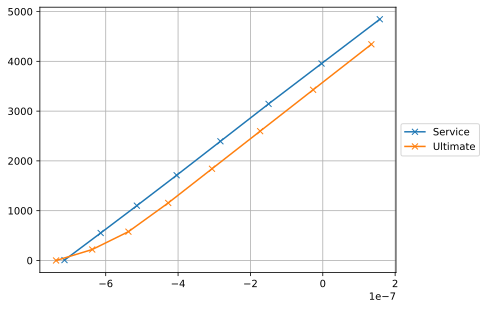

In [21]:
fix, ax = plt.subplots()  # create plot
m_serv = np.array(mk_serv.m_x[:8]) / 1e6  # get service analysis moments
m_ult = np.array(mk_ult.m_x[:8]) / 1e6  # get ultimate analysis moments
ax.plot(mk_serv.kappa[:8], m_serv, "x-", label="Service")
ax.plot(mk_ult.kappa[:8], m_ult, "x-", label="Ultimate")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.grid()
plt.show()

Another point of interest on the moment curvature diagram is around 8000 kN.m. At this magnitude of external moment, the section in the service analysis remains uncracked (just below the flexural tensile strenght). However, the section in the ultimate analysis has started to crack and the bending stiffness has begun to soften. Note also the resulting increase in concrete compressive stress to compensate.

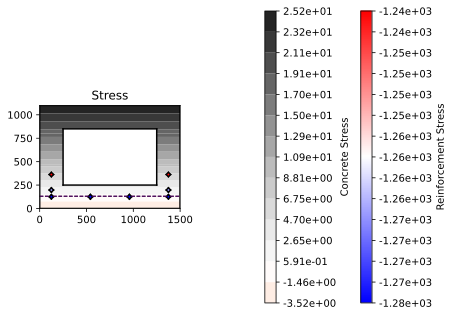

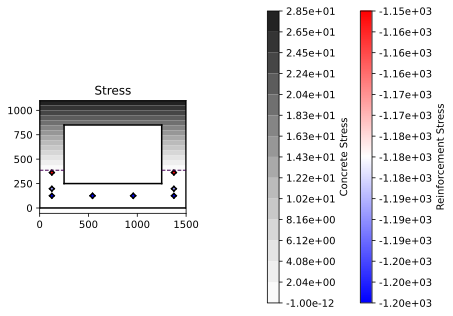

<Axes: title={'center': 'Stress'}>

In [22]:
serv_stress_s_2 = conc_sec_serv.calculate_service_stress(
    moment_curvature_results=mk_serv, m=8000e6
)
serv_stress_u_2 = conc_sec_ult.calculate_service_stress(
    moment_curvature_results=mk_ult, m=8000e6
)
serv_stress_s_2.plot_stress()
serv_stress_u_2.plot_stress()